# **UNIVERSIDAD TORCUATO DI TELLA**
## **MAESTRÍA EN ECONOMETRÍA**

---

### **EXAMEN DE ECONOMETRÍA DE DATOS DE PANEL**

- **Profesor:** González-Rozada, Martín  
- **Ayudante:** Lening, Iara  
- **Alumno:** Guzzi, David Alexander  (Legajo n°: 24H1970, DNI: 37.703.649)  

**Ciclo Lectivo:** Primer Trimestre, 2025

---

In [ ]:
# Script para replicar Tablas 1, 2, 3 y Figura 1 del paper de Sadoon et al. (2019)

import numpy as np
import pandas as pd
from pydynpd import regression
import contextlib
import os
import sys
from scipy import stats
from datetime import datetime
import multiprocessing as mp

# ------------------- Silenciar prints -------------------
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

# ------------------- Configuración global -------------------
seed = int('03649')
np.random.seed(seed)
T_total_default = 20 
T_drop = 13
rho_values = [0.25, 0.5, 0.75]
N_values = [500, 5000]
selection_models = ['A', 'B']
reps = 500

# ------------------- Generador de datos -------------------
def generate_panel_data(N, rho, selection_type, T_total=T_total_default,
                        selection_rate=0.85,
                        sigma_alpha_ratio=1,
                        correlation=0.447,
                        non_stationary=False,
                        experiment_label='',
                        seed_offset=0):
    
    # Usar semilla única para cada simulación
    np.random.seed(seed + seed_offset)
    
    # Parámetros base
    sigma_eta = 1
    sigma_u = 1
    sigma_alpha0 = sigma_alpha_ratio
    sigma_epsilon0 = 1

    # Generar componentes base independientes
    eta_i = np.random.normal(0, sigma_eta, N)
    alpha0_i = np.random.normal(0, sigma_alpha0, N)
    
    # Variables exógenas y errores base
    z = np.random.normal(0, 1, (N, T_total))
    u = np.random.normal(0, sigma_u, (N, T_total))
    epsilon0 = np.random.normal(0, sigma_epsilon0, (N, T_total))
    
    # Correlaciones
    if correlation > 0:
        # αi = α0i + θ0ηi, εit = ε0it + ϑ0uit con θ0 = ϑ0 = 0.5 para corr = 0.447
        correlation_param = 0.5 if abs(correlation - 0.447) < 0.01 else 0.25  # 0.25 para corr ≈ 0.242
        alpha_i = alpha0_i + correlation_param * eta_i
        epsilon = epsilon0 + correlation_param * u
    else:
        alpha_i = alpha0_i
        epsilon = epsilon0
    
    # No estacionario
    if non_stationary:
        scaling = np.random.binomial(1, 0.5, size=(N, T_total)) + 1  # 1 o 2
        epsilon *= scaling
        u *= scaling

    # Generar y*it
    y = np.zeros((N, T_total))
    # Condición inicial (t=1): y*i1 = (2 + αi + εi1)/(1 - ρ)
    y[:, 0] = (2 + alpha_i + epsilon[:, 0]) / (1 - rho)
    # Proceso AR(1): y*it = 2 + ρy*it-1 + αi + εit
    for t in range(1, T_total):
        y[:, t] = 2 + rho * y[:, t - 1] + alpha_i + epsilon[:, t]

    # Calibrar constante 'a' para lograr la tasa de selección deseada # P(d*it > 0) = selection_rate
    if selection_type == 'A':
        a = stats.norm.ppf(selection_rate) * 1.732  # sqrt(3)
    elif selection_type == 'B':
        a = stats.norm.ppf(selection_rate) * 1.85  
    
    # Proceso de selección
    d = np.zeros((N, T_total))
    d_star = np.zeros((N, T_total))
    
    if selection_type == 'A':
        # Modelo estático: d*it = a - zit - ηi - uit (ecuación 40)
        d_star = a - z - eta_i[:, None] - u
        d = (d_star > 0).astype(int)
        
    elif selection_type == 'B':
        # Modelo dinámico: d*it = a - 0.5dit-1 + zit - ηi - uit (ecuación 41)
        for t in range(T_total):
            if t == 0:
                # Primera observación sin rezago
                d_star[:, t] = a + z[:, t] - eta_i - u[:, t]
            else:
                # Con rezago dinámico
                d_star[:, t] = a - 0.5 * d[:, t-1] + z[:, t] - eta_i - u[:, t]
            d[:, t] = (d_star[:, t] > 0).astype(int)
    else:
        raise ValueError("Tipo de selección debe ser 'A' o 'B'")

    # Ajuste específico para short_T
    if experiment_label == 'short_T':
        start_t = 1
        T_drop_adj = 14 
        min_consecutive = 2 
    else:
        start_t = 2
        T_drop_adj = T_drop  
        min_consecutive = 3

    # Descartar primeras T_drop_adj observaciones
    y_final = y[:, T_drop_adj:]
    d_final = d[:, T_drop_adj:]
    T_effective = T_total - T_drop_adj

    panel = []
    for i in range(N):
        for t in range(start_t, T_effective):
            if min_consecutive == 2:
                # Solo 2 períodos consecutivos
                if d_final[i, t] == d_final[i, t-1] == 1:
                    panel.append({
                        'id': i + 1,
                        'year': t + 1,
                        'n': y_final[i, t],
                        'L1.n': y_final[i, t-1],
                        'L2.n': y_final[i, t-2] if t >= 2 else y_final[i, t-1],
                    })
            else:
                # 3 períodos consecutivos (caso normal)
                if d_final[i, t] == d_final[i, t-1] == d_final[i, t-2] == 1:
                    panel.append({
                        'id': i + 1,
                        'year': t + 1,
                        'n': y_final[i, t],
                        'L1.n': y_final[i, t-1],
                        'L2.n': y_final[i, t-2],
                    })

    return pd.DataFrame(panel)

# ------------------- Extraer coeficientes -------------------
def get_coefs(model, variable='L1.n'):
    """Extrae coeficiente y error estándar de la regresión"""
    try:
        table = model.models[0].regression_table
        row = table[table['variable'] == variable]
        if not row.empty:
            coef = row['coefficient'].values[0]
            se = row['std_err'].values[0]
            return coef, se
        else:
            return np.nan, np.nan
    except Exception:
        return np.nan, np.nan
    

def get_timestamp():
    """Retorna timestamp formateado para logging"""
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# ------------------- Función auxiliar para una replicación -------------------
def run_single_replication(args):
    """Ejecuta una sola replicación - diseñada para paralelización"""
    (N, rho, sel_model, expt_label, T_total, selection_rate, 
     sigma_alpha_ratio, correlation, non_stationary, rep_id) = args
    
    try:
        # Generar datos con semilla única
        df = generate_panel_data(N, rho, sel_model,
                                 T_total=T_total,
                                 selection_rate=selection_rate,
                                 sigma_alpha_ratio=sigma_alpha_ratio,
                                 correlation=correlation,
                                 non_stationary=non_stationary,
                                 experiment_label=expt_label,
                                 seed_offset=rep_id * 1000)  # Semilla única
        
        min_obs = 10 if expt_label != 'short_T' else 3
        
        if len(df) < min_obs:
            return None
            
        with suppress_output():
            model_ab = regression.abond('n L1.n | gmm(n, 2:99) | nolevel', 
                                      df, ['id', 'year'])
            model_sys = regression.abond('n L1.n | gmm(n, 2:99)', 
                                       df, ['id', 'year'])
        
        ab_coef, ab_se = get_coefs(model_ab, 'L1.n')
        sys_coef, sys_se = get_coefs(model_sys, 'L1.n')
        
        result = {
            'ab_bias': ab_coef - rho if not np.isnan(ab_coef) else np.nan,
            'ab_se': ab_se if not np.isnan(ab_coef) else np.nan,
            'sys_bias': sys_coef - rho if not np.isnan(sys_coef) else np.nan,
            'sys_se': sys_se if not np.isnan(sys_coef) else np.nan,
            'ab_valid': not np.isnan(ab_coef),
            'sys_valid': not np.isnan(sys_coef)
        }
        
        return result
        
    except Exception as e:
        return None

# ------------------- Función de simulación PARALELIZADA -------------------
def run_simulation(N, rho, sel_model, expt_label='',
                   T_total=T_total_default,
                   selection_rate=0.85,
                   sigma_alpha_ratio=1,
                   correlation=0.447,
                   non_stationary=False,
                   n_reps=None):  # Nuevo parámetro

    # Usar n_reps si se proporciona, sino usar global reps
    num_reps = n_reps if n_reps is not None else reps
    
    # Solo mostrar detalles para experimentos principales
    verbose = expt_label != 'figure1'
    
    if verbose:
        print(f"  Simulando: {expt_label} N={N} ρ={rho} Modelo={sel_model} ({num_reps} reps) [{get_timestamp()}]")
    
    # Crear argumentos para cada replicación
    args_list = []
    for rep in range(num_reps):
        args = (N, rho, sel_model, expt_label, T_total, selection_rate,
                sigma_alpha_ratio, correlation, non_stationary, rep)
        args_list.append(args)
    
    # Determinar número de cores a usar
    cores = min(mp.cpu_count(), 18)
    
    # Ejecutar en paralelo
    with mp.Pool(processes=cores) as pool:
        results = pool.map(run_single_replication, args_list)
        
        # Mostrar progreso durante la ejecución para experimentos verbosos
        if verbose:
            completed = sum(1 for r in results if r is not None)
            if completed > 0:
                print(f"    Progreso: {completed}/{num_reps} replicaciones completadas")
    
    # Procesar resultados
    valid_results = [r for r in results if r is not None]
    
    if not valid_results:
        return {
            'N': N, 'rho': rho, 'selection': sel_model, 'expt': expt_label,
            'AB_bias': np.nan, 'AB_se': np.nan, 'SYS_bias': np.nan, 'SYS_se': np.nan,
            'AB_reps': 0, 'SYS_reps': 0, 'total_reps': num_reps
        }
    
    # Separar resultados válidos para AB y SYS
    ab_results = [r for r in valid_results if r['ab_valid']]
    sys_results = [r for r in valid_results if r['sys_valid']]
    
    # Calcular estadísticas finales
    result = {
        'N': N,
        'rho': rho,
        'selection': sel_model,
        'expt': expt_label,
        'AB_bias': np.mean([r['ab_bias'] for r in ab_results]) if ab_results else np.nan,
        'AB_se': np.mean([r['ab_se'] for r in ab_results]) if ab_results else np.nan,
        'SYS_bias': np.mean([r['sys_bias'] for r in sys_results]) if sys_results else np.nan,
        'SYS_se': np.mean([r['sys_se'] for r in sys_results]) if sys_results else np.nan,
        'AB_reps': len(ab_results),
        'SYS_reps': len(sys_results),
        'total_reps': num_reps
    }
    
    if verbose:
        print(f"    ✓ AB: {result['AB_bias']:.4f} ({result['AB_reps']}/{num_reps} válidas)")
        print(f"    ✓ SYS: {result['SYS_bias']:.4f} ({result['SYS_reps']}/{num_reps} válidas)")
    
    return result

# ------------------- Configuración de experimentos -------------------
experiments = [
    # TABLA 1 - Parte 1: Sin selección endógena
    {
        'label': 'no_endogenous', 
        'T_total': 20,
        'selection_rate': 0.85, 
        'sigma_alpha_ratio': 1, 
        'correlation': 0.0,  # SIN correlación
        'non_stationary': False
    },
    # TABLA 1 - Parte 2: Con selección endógena (baseline)
    {
        'label': 'baseline', 
        'T_total': 20,
        'selection_rate': 0.85, 
        'sigma_alpha_ratio': 1, 
        'correlation': 0.447,  # CON correlación
        'non_stationary': False
    },
    # TABLAS 2-3: Experimentos de sensibilidad
    {
        'label': 'short_T', 
        'T_total': 20,  # (Experimento I)
        'selection_rate': 0.85,  
        'sigma_alpha_ratio': 1, 
        'correlation': 0.447, 
        'non_stationary': False
    },
    {
        'label': 'more_selection', 
        'T_total': 20, 
        'selection_rate': 0.75,  # 25% selección (Experimento II)
        'sigma_alpha_ratio': 1, 
        'correlation': 0.447, 
        'non_stationary': False
    },
    {
        'label': 'high_alpha_ratio', 
        'T_total': 20, 
        'selection_rate': 0.85, 
        'sigma_alpha_ratio': 2,  # ση/σε = 2 (Experimento III)
        'correlation': 0.447, 
        'non_stationary': False
    },
    {
        'label': 'low_corr', 
        'T_total': 20, 
        'selection_rate': 0.85, 
        'sigma_alpha_ratio': 1, 
        'correlation': 0.242,  # ρ = 0.25 (Experimento IV)
        'non_stationary': False
    },
    {
        'label': 'nonstationary', 
        'T_total': 20, 
        'selection_rate': 0.85, 
        'sigma_alpha_ratio': 1, 
        'correlation': 0.447, 
        'non_stationary': True  # Experimento V
    },
]

# ------------------- Experimento especial para Figura 1 -------------------
def run_figure1_simulation():
    """Simulación especial para Figura 1 con varios tamaños de muestra."""
    
    # Tamaños de muestra para la figura
    N_figure = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000, 4200, 4400, 4600, 4800, 5000]
    rho_figure = [0.25, 0.5, 0.75]
    reps_figure = 500 
    
    figure_results = []
    total_sims = len(N_figure) * len(rho_figure) * 2  # 2 modelos de selección
    current_sim = 0
    
    print(f"Simulando {total_sims} configuraciones...")
    print(f"Usando {reps_figure} replicaciones por configuración")
    
    for N in N_figure:
        for rho in rho_figure:
            for sel_model in ['A', 'B']:
                current_sim += 1
                
                # Mostrar progreso cada 10 simulaciones
                if current_sim % 10 == 0 or current_sim == 1:
                    print(f"  [{current_sim}/{total_sims}] N={N}, ρ={rho}, Modelo={sel_model} [{get_timestamp()}]")

                res = run_simulation(N, rho, sel_model, 
                                   expt_label='figure1',
                                   T_total=20,
                                   selection_rate=0.85,
                                   sigma_alpha_ratio=1,
                                   correlation=0.447,
                                   non_stationary=False,
                                   n_reps=reps_figure) 
                
                # Cambiar label para identificar
                res['expt'] = 'figure1'
                figure_results.append(res)
    
    print(f"Figura 1 completada con {reps_figure} reps cada una [{get_timestamp()}]")
    return figure_results

# ------------------- EJECUTAR TODO -------------------
if __name__ == "__main__":

    # ------------------- Ejecutar simulaciones -------------------
    print("="*80)
    print(f"REPLICACIÓN SADOON ET AL. (2019) - INICIO: {get_timestamp()}")
    print(f"Semilla: {seed} | Replicaciones por experimento: {reps}")
    print(f"Cores disponibles: {mp.cpu_count()}")
    print("="*80)

    all_results = []

    # 1. EXPERIMENTOS PRINCIPALES (Tablas 1-3) con N = [500, 5000]
    total_experiments = len(experiments) * len(N_values) * len(rho_values) * len(selection_models)
    current_exp = 0

    for expt in experiments:
        print(f"\n--- EXPERIMENTO: {expt['label'].upper()} --- [{get_timestamp()}]")
        for N in N_values:
            for rho in rho_values:
                for sel_model in selection_models:
                    current_exp += 1
                    print(f"[{current_exp}/{total_experiments}]", end=" ")
                    
                    res = run_simulation(N, rho, sel_model, 
                                    expt_label=expt['label'],
                                    T_total=expt['T_total'],
                                    selection_rate=expt['selection_rate'],
                                    sigma_alpha_ratio=expt['sigma_alpha_ratio'],
                                    correlation=expt['correlation'],
                                    non_stationary=expt['non_stationary'])
                    all_results.append(res)

    # 2. SIMULACIÓN ESPECIAL PARA FIGURA 1
    print(f"\n{'='*80}")
    print(f"EJECUTANDO SIMULACIÓN ESPECIAL PARA FIGURA 1 - INICIO: {get_timestamp()}")
    print("(Varios tamaños de muestra para obtener líneas suaves)")
    print(f"{'='*80}")

    figure_results = run_figure1_simulation()
    all_results.extend(figure_results)

    # ------------------- Guardar resultados -------------------
    df_all = pd.DataFrame(all_results)
    df_all = df_all.round(5)  # Redondear para prolijidad
    df_all.to_csv('resultados_v2.csv', index=False)

    print("\n" + "="*80)
    print(f"SIMULACIONES COMPLETADAS - FIN: {get_timestamp()}")
    print(f"Resultados guardados en 'resultados_v2.csv'")
    print(f"Total de experimentos: {len(df_all)}")
    print("Experimentos incluidos:")
    for exp_name in df_all['expt'].unique():
        count = len(df_all[df_all['expt'] == exp_name])
        print(f"   - {exp_name}: {count} configuraciones")
    print("="*80)

Dado que el proceso de ejecución del anterior script insume mucho tiempo, el mismo fue ejecutado en una máquina virtual (VM) con mejor poder de procesamiento. Se deja detallado aquí debajo el log de dicho proceso, cuyo resultado es el archivo **"resultados.csv".**

```bash

================================================================================
REPLICACIÓN SADOON ET AL. (2019) - INICIO: 2025-07-14 03:17:55
Semilla: 3649 | Replicaciones por experimento: 500
Cores disponibles: 20
================================================================================

--- EXPERIMENTO: NO_ENDOGENOUS --- [2025-07-14 03:17:55]
[1/84]   Simulando: no_endogenous N=500 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:17:55]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0152 (500/500 válidas)
    ✓ SYS: 0.0046 (500/500 válidas)
[2/84]   Simulando: no_endogenous N=500 ρ=0.25 Modelo=B (500 reps) [2025-07-14 03:18:02]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0278 (500/500 válidas)
    ✓ SYS: 0.0051 (500/500 válidas)
[3/84]   Simulando: no_endogenous N=500 ρ=0.5 Modelo=A (500 reps) [2025-07-14 03:18:08]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0567 (500/500 válidas)
    ✓ SYS: 0.0041 (500/500 válidas)
[4/84]   Simulando: no_endogenous N=500 ρ=0.5 Modelo=B (500 reps) [2025-07-14 03:18:15]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0858 (500/500 válidas)
    ✓ SYS: 0.0051 (500/500 válidas)
[5/84]   Simulando: no_endogenous N=500 ρ=0.75 Modelo=A (500 reps) [2025-07-14 03:18:21]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.3516 (500/500 válidas)
    ✓ SYS: 0.0079 (500/500 válidas)
[6/84]   Simulando: no_endogenous N=500 ρ=0.75 Modelo=B (500 reps) [2025-07-14 03:18:28]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.3948 (500/500 válidas)
    ✓ SYS: 0.0079 (500/500 válidas)
[7/84]   Simulando: no_endogenous N=5000 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:18:34]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0015 (500/500 válidas)
    ✓ SYS: 0.0009 (500/500 válidas)
[8/84]   Simulando: no_endogenous N=5000 ρ=0.25 Modelo=B (500 reps) [2025-07-14 03:20:43]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0002 (500/500 válidas)
    ✓ SYS: 0.0015 (500/500 válidas)
[9/84]   Simulando: no_endogenous N=5000 ρ=0.5 Modelo=A (500 reps) [2025-07-14 03:22:47]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0073 (500/500 válidas)
    ✓ SYS: 0.0013 (500/500 válidas)
[10/84]   Simulando: no_endogenous N=5000 ρ=0.5 Modelo=B (500 reps) [2025-07-14 03:24:58]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0044 (500/500 válidas)
    ✓ SYS: 0.0017 (500/500 válidas)
[11/84]   Simulando: no_endogenous N=5000 ρ=0.75 Modelo=A (500 reps) [2025-07-14 03:27:03]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0489 (500/500 válidas)
    ✓ SYS: 0.0016 (500/500 válidas)
[12/84]   Simulando: no_endogenous N=5000 ρ=0.75 Modelo=B (500 reps) [2025-07-14 03:29:12]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0480 (500/500 válidas)
    ✓ SYS: 0.0018 (500/500 válidas)

--- EXPERIMENTO: BASELINE --- [2025-07-14 03:31:16]
[13/84]   Simulando: baseline N=500 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:31:16]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0146 (500/500 válidas)
    ✓ SYS: 0.0048 (500/500 válidas)
[14/84]   Simulando: baseline N=500 ρ=0.25 Modelo=B (500 reps) [2025-07-14 03:31:23]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0283 (500/500 válidas)
    ✓ SYS: 0.0033 (500/500 válidas)
[15/84]   Simulando: baseline N=500 ρ=0.5 Modelo=A (500 reps) [2025-07-14 03:31:29]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0461 (500/500 válidas)
    ✓ SYS: 0.0029 (500/500 válidas)
[16/84]   Simulando: baseline N=500 ρ=0.5 Modelo=B (500 reps) [2025-07-14 03:31:36]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0712 (500/500 válidas)
    ✓ SYS: 0.0018 (500/500 válidas)
[17/84]   Simulando: baseline N=500 ρ=0.75 Modelo=A (500 reps) [2025-07-14 03:31:42]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.2039 (500/500 válidas)
    ✓ SYS: 0.0007 (500/500 válidas)
[18/84]   Simulando: baseline N=500 ρ=0.75 Modelo=B (500 reps) [2025-07-14 03:31:49]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.2327 (500/500 válidas)
    ✓ SYS: 0.0015 (500/500 válidas)
[19/84]   Simulando: baseline N=5000 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:31:56]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0013 (500/500 válidas)
    ✓ SYS: 0.0007 (500/500 válidas)
[20/84]   Simulando: baseline N=5000 ρ=0.25 Modelo=B (500 reps) [2025-07-14 03:34:04]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: 0.0012 (500/500 válidas)
    ✓ SYS: 0.0018 (500/500 válidas)
[21/84]   Simulando: baseline N=5000 ρ=0.5 Modelo=A (500 reps) [2025-07-14 03:36:08]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0060 (500/500 válidas)
    ✓ SYS: -0.0006 (500/500 válidas)
[22/84]   Simulando: baseline N=5000 ρ=0.5 Modelo=B (500 reps) [2025-07-14 03:38:16]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0011 (500/500 válidas)
    ✓ SYS: 0.0001 (500/500 válidas)
[23/84]   Simulando: baseline N=5000 ρ=0.75 Modelo=A (500 reps) [2025-07-14 03:40:22]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0254 (500/500 válidas)
    ✓ SYS: -0.0061 (500/500 válidas)
[24/84]   Simulando: baseline N=5000 ρ=0.75 Modelo=B (500 reps) [2025-07-14 03:42:31]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0154 (500/500 válidas)
    ✓ SYS: -0.0058 (500/500 válidas)

--- EXPERIMENTO: SHORT_T --- [2025-07-14 03:44:35]
[25/84]   Simulando: short_T N=500 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:44:35]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0136 (500/500 válidas)
    ✓ SYS: 0.0035 (500/500 válidas)
[26/84]   Simulando: short_T N=500 ρ=0.25 Modelo=B (500 reps) [2025-07-14 03:44:43]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0227 (500/500 válidas)
    ✓ SYS: 0.0034 (500/500 válidas)
[27/84]   Simulando: short_T N=500 ρ=0.5 Modelo=A (500 reps) [2025-07-14 03:44:49]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0427 (500/500 válidas)
    ✓ SYS: -0.0002 (500/500 válidas)
[28/84]   Simulando: short_T N=500 ρ=0.5 Modelo=B (500 reps) [2025-07-14 03:44:57]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0574 (500/500 válidas)
    ✓ SYS: 0.0006 (500/500 válidas)
[29/84]   Simulando: short_T N=500 ρ=0.75 Modelo=A (500 reps) [2025-07-14 03:45:04]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.1632 (500/500 válidas)
    ✓ SYS: -0.0036 (500/500 válidas)
[30/84]   Simulando: short_T N=500 ρ=0.75 Modelo=B (500 reps) [2025-07-14 03:45:11]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.1790 (500/500 válidas)
    ✓ SYS: -0.0006 (500/500 válidas)
[31/84]   Simulando: short_T N=5000 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:45:18]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0010 (500/500 válidas)
    ✓ SYS: 0.0004 (500/500 válidas)
[32/84]   Simulando: short_T N=5000 ρ=0.25 Modelo=B (500 reps) [2025-07-14 03:47:32]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0006 (500/500 válidas)
    ✓ SYS: 0.0008 (500/500 válidas)
[33/84]   Simulando: short_T N=5000 ρ=0.5 Modelo=A (500 reps) [2025-07-14 03:49:45]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0047 (500/500 válidas)
    ✓ SYS: -0.0024 (500/500 válidas)
[34/84]   Simulando: short_T N=5000 ρ=0.5 Modelo=B (500 reps) [2025-07-14 03:52:00]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0039 (500/500 válidas)
    ✓ SYS: -0.0026 (500/500 válidas)
[35/84]   Simulando: short_T N=5000 ρ=0.75 Modelo=A (500 reps) [2025-07-14 03:54:15]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0193 (500/500 válidas)
    ✓ SYS: -0.0094 (500/500 válidas)
[36/84]   Simulando: short_T N=5000 ρ=0.75 Modelo=B (500 reps) [2025-07-14 03:56:31]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0157 (500/500 válidas)
    ✓ SYS: -0.0098 (500/500 válidas)

--- EXPERIMENTO: MORE_SELECTION --- [2025-07-14 03:58:44]
[37/84]   Simulando: more_selection N=500 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:58:44]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0218 (500/500 válidas)
    ✓ SYS: 0.0059 (500/500 válidas)
[38/84]   Simulando: more_selection N=500 ρ=0.25 Modelo=B (500 reps) [2025-07-14 03:58:50]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0453 (500/500 válidas)
    ✓ SYS: 0.0091 (500/500 válidas)
[39/84]   Simulando: more_selection N=500 ρ=0.5 Modelo=A (500 reps) [2025-07-14 03:58:55]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0650 (500/500 válidas)
    ✓ SYS: 0.0039 (500/500 válidas)
[40/84]   Simulando: more_selection N=500 ρ=0.5 Modelo=B (500 reps) [2025-07-14 03:59:01]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.1130 (500/500 válidas)
    ✓ SYS: 0.0069 (500/500 válidas)
[41/84]   Simulando: more_selection N=500 ρ=0.75 Modelo=A (500 reps) [2025-07-14 03:59:07]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.2393 (500/500 válidas)
    ✓ SYS: 0.0024 (500/500 válidas)
[42/84]   Simulando: more_selection N=500 ρ=0.75 Modelo=B (500 reps) [2025-07-14 03:59:13]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.3100 (500/500 válidas)
    ✓ SYS: 0.0077 (500/500 válidas)
[43/84]   Simulando: more_selection N=5000 ρ=0.25 Modelo=A (500 reps) [2025-07-14 03:59:18]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0014 (500/500 válidas)
    ✓ SYS: 0.0011 (500/500 válidas)
[44/84]   Simulando: more_selection N=5000 ρ=0.25 Modelo=B (500 reps) [2025-07-14 04:01:17]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0004 (500/500 válidas)
    ✓ SYS: 0.0021 (500/500 válidas)
[45/84]   Simulando: more_selection N=5000 ρ=0.5 Modelo=A (500 reps) [2025-07-14 04:02:54]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0074 (500/500 válidas)
    ✓ SYS: -0.0008 (500/500 válidas)
[46/84]   Simulando: more_selection N=5000 ρ=0.5 Modelo=B (500 reps) [2025-07-14 04:04:50]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0064 (500/500 válidas)
    ✓ SYS: 0.0005 (500/500 válidas)
[47/84]   Simulando: more_selection N=5000 ρ=0.75 Modelo=A (500 reps) [2025-07-14 04:06:27]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0299 (500/500 válidas)
    ✓ SYS: -0.0072 (500/500 válidas)
[48/84]   Simulando: more_selection N=5000 ρ=0.75 Modelo=B (500 reps) [2025-07-14 04:08:23]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0295 (500/500 válidas)
    ✓ SYS: -0.0055 (500/500 válidas)

--- EXPERIMENTO: HIGH_ALPHA_RATIO --- [2025-07-14 04:09:59]
[49/84]   Simulando: high_alpha_ratio N=500 ρ=0.25 Modelo=A (500 reps) [2025-07-14 04:09:59]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0205 (500/500 válidas)
    ✓ SYS: 0.0151 (500/500 válidas)
[50/84]   Simulando: high_alpha_ratio N=500 ρ=0.25 Modelo=B (500 reps) [2025-07-14 04:10:06]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0382 (500/500 válidas)
    ✓ SYS: 0.0168 (500/500 válidas)
[51/84]   Simulando: high_alpha_ratio N=500 ρ=0.5 Modelo=A (500 reps) [2025-07-14 04:10:12]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0686 (500/500 válidas)
    ✓ SYS: 0.0202 (500/500 válidas)
[52/84]   Simulando: high_alpha_ratio N=500 ρ=0.5 Modelo=B (500 reps) [2025-07-14 04:10:19]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.1050 (500/500 válidas)
    ✓ SYS: 0.0250 (500/500 válidas)
[53/84]   Simulando: high_alpha_ratio N=500 ρ=0.75 Modelo=A (500 reps) [2025-07-14 04:10:26]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.2950 (500/500 válidas)
    ✓ SYS: 0.0408 (500/500 válidas)
[54/84]   Simulando: high_alpha_ratio N=500 ρ=0.75 Modelo=B (500 reps) [2025-07-14 04:10:33]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.3506 (500/500 válidas)
    ✓ SYS: 0.0495 (500/500 válidas)
[55/84]   Simulando: high_alpha_ratio N=5000 ρ=0.25 Modelo=A (500 reps) [2025-07-14 04:10:39]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0015 (500/500 válidas)
    ✓ SYS: 0.0011 (500/500 válidas)
[56/84]   Simulando: high_alpha_ratio N=5000 ρ=0.25 Modelo=B (500 reps) [2025-07-14 04:12:48]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: 0.0013 (500/500 válidas)
    ✓ SYS: 0.0034 (500/500 válidas)
[57/84]   Simulando: high_alpha_ratio N=5000 ρ=0.5 Modelo=A (500 reps) [2025-07-14 04:14:51]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0076 (500/500 válidas)
    ✓ SYS: 0.0008 (500/500 válidas)
[58/84]   Simulando: high_alpha_ratio N=5000 ρ=0.5 Modelo=B (500 reps) [2025-07-14 04:17:00]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0025 (500/500 válidas)
    ✓ SYS: 0.0030 (500/500 válidas)
[59/84]   Simulando: high_alpha_ratio N=5000 ρ=0.75 Modelo=A (500 reps) [2025-07-14 04:19:04]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0369 (500/500 válidas)
    ✓ SYS: -0.0028 (500/500 válidas)
[60/84]   Simulando: high_alpha_ratio N=5000 ρ=0.75 Modelo=B (500 reps) [2025-07-14 04:21:13]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0274 (500/500 válidas)
    ✓ SYS: -0.0007 (500/500 válidas)

--- EXPERIMENTO: LOW_CORR --- [2025-07-14 04:23:18]
[61/84]   Simulando: low_corr N=500 ρ=0.25 Modelo=A (500 reps) [2025-07-14 04:23:18]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0152 (500/500 válidas)
    ✓ SYS: 0.0049 (500/500 válidas)
[62/84]   Simulando: low_corr N=500 ρ=0.25 Modelo=B (500 reps) [2025-07-14 04:23:24]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0290 (500/500 válidas)
    ✓ SYS: 0.0044 (500/500 válidas)
[63/84]   Simulando: low_corr N=500 ρ=0.5 Modelo=A (500 reps) [2025-07-14 04:23:31]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0523 (500/500 válidas)
    ✓ SYS: 0.0042 (500/500 válidas)
[64/84]   Simulando: low_corr N=500 ρ=0.5 Modelo=B (500 reps) [2025-07-14 04:23:38]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0807 (500/500 válidas)
    ✓ SYS: 0.0041 (500/500 válidas)
[65/84]   Simulando: low_corr N=500 ρ=0.75 Modelo=A (500 reps) [2025-07-14 04:23:44]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.2712 (500/500 válidas)
    ✓ SYS: 0.0064 (500/500 válidas)
[66/84]   Simulando: low_corr N=500 ρ=0.75 Modelo=B (500 reps) [2025-07-14 04:23:51]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.3136 (500/500 válidas)
    ✓ SYS: 0.0066 (500/500 válidas)
[67/84]   Simulando: low_corr N=5000 ρ=0.25 Modelo=A (500 reps) [2025-07-14 04:23:57]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0015 (500/500 válidas)
    ✓ SYS: 0.0008 (500/500 válidas)
[68/84]   Simulando: low_corr N=5000 ρ=0.25 Modelo=B (500 reps) [2025-07-14 04:26:05]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: 0.0005 (500/500 válidas)
    ✓ SYS: 0.0017 (500/500 válidas)
[69/84]   Simulando: low_corr N=5000 ρ=0.5 Modelo=A (500 reps) [2025-07-14 04:28:09]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0068 (500/500 válidas)
    ✓ SYS: 0.0008 (500/500 válidas)
[70/84]   Simulando: low_corr N=5000 ρ=0.5 Modelo=B (500 reps) [2025-07-14 04:30:18]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0026 (500/500 válidas)
    ✓ SYS: 0.0014 (500/500 válidas)
[71/84]   Simulando: low_corr N=5000 ρ=0.75 Modelo=A (500 reps) [2025-07-14 04:32:22]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0351 (500/500 válidas)
    ✓ SYS: -0.0006 (500/500 válidas)
[72/84]   Simulando: low_corr N=5000 ρ=0.75 Modelo=B (500 reps) [2025-07-14 04:34:32]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0265 (500/500 válidas)
    ✓ SYS: -0.0001 (500/500 válidas)

--- EXPERIMENTO: NONSTATIONARY --- [2025-07-14 04:36:36]
[73/84]   Simulando: nonstationary N=500 ρ=0.25 Modelo=A (500 reps) [2025-07-14 04:36:36]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0131 (500/500 válidas)
    ✓ SYS: 0.0011 (500/500 válidas)
[74/84]   Simulando: nonstationary N=500 ρ=0.25 Modelo=B (500 reps) [2025-07-14 04:36:42]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0200 (500/500 válidas)
    ✓ SYS: 0.0028 (500/500 válidas)
[75/84]   Simulando: nonstationary N=500 ρ=0.5 Modelo=A (500 reps) [2025-07-14 04:36:48]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0327 (500/500 válidas)
    ✓ SYS: -0.0008 (500/500 válidas)
[76/84]   Simulando: nonstationary N=500 ρ=0.5 Modelo=B (500 reps) [2025-07-14 04:36:55]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0475 (500/500 válidas)
    ✓ SYS: 0.0007 (500/500 válidas)
[77/84]   Simulando: nonstationary N=500 ρ=0.75 Modelo=A (500 reps) [2025-07-14 04:37:01]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.1119 (500/500 válidas)
    ✓ SYS: -0.0043 (500/500 válidas)
[78/84]   Simulando: nonstationary N=500 ρ=0.75 Modelo=B (500 reps) [2025-07-14 04:37:07]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.1398 (500/500 válidas)
    ✓ SYS: -0.0043 (500/500 válidas)
[79/84]   Simulando: nonstationary N=5000 ρ=0.25 Modelo=A (500 reps) [2025-07-14 04:37:13]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0007 (500/500 válidas)
    ✓ SYS: 0.0012 (500/500 válidas)
[80/84]   Simulando: nonstationary N=5000 ρ=0.25 Modelo=B (500 reps) [2025-07-14 04:39:18]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: 0.0016 (500/500 válidas)
    ✓ SYS: 0.0024 (500/500 válidas)
[81/84]   Simulando: nonstationary N=5000 ρ=0.5 Modelo=A (500 reps) [2025-07-14 04:41:19]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0039 (500/500 válidas)
    ✓ SYS: 0.0002 (500/500 válidas)
[82/84]   Simulando: nonstationary N=5000 ρ=0.5 Modelo=B (500 reps) [2025-07-14 04:43:25]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0000 (500/500 válidas)
    ✓ SYS: 0.0011 (500/500 válidas)
[83/84]   Simulando: nonstationary N=5000 ρ=0.75 Modelo=A (500 reps) [2025-07-14 04:45:26]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0147 (500/500 válidas)
    ✓ SYS: -0.0037 (500/500 válidas)
[84/84]   Simulando: nonstationary N=5000 ρ=0.75 Modelo=B (500 reps) [2025-07-14 04:47:32]
    Progreso: 500/500 replicaciones completadas
    ✓ AB: -0.0074 (500/500 válidas)
    ✓ SYS: -0.0031 (500/500 válidas)

================================================================================
EJECUTANDO SIMULACIÓN ESPECIAL PARA FIGURA 1 - INICIO: 2025-07-14 04:49:33
(Varios tamaños de muestra para obtener líneas suaves)
================================================================================
Simulando 150 configuraciones...
Usando 500 replicaciones por configuración
  [1/150] N=200, ρ=0.25, Modelo=A [2025-07-14 04:49:33]
  [10/150] N=400, ρ=0.5, Modelo=B [2025-07-14 04:50:07]
  [20/150] N=800, ρ=0.25, Modelo=B [2025-07-14 04:51:37]
  [30/150] N=1000, ρ=0.75, Modelo=B [2025-07-14 04:56:17]
  [40/150] N=1400, ρ=0.5, Modelo=B [2025-07-14 05:02:14]
  [50/150] N=1800, ρ=0.25, Modelo=B [2025-07-14 05:09:13]
  [60/150] N=2000, ρ=0.75, Modelo=B [2025-07-14 05:18:34]
  [70/150] N=2400, ρ=0.5, Modelo=B [2025-07-14 05:28:55]
  [80/150] N=2800, ρ=0.25, Modelo=B [2025-07-14 05:40:10]
  [90/150] N=3000, ρ=0.75, Modelo=B [2025-07-14 05:52:16]
  [100/150] N=3400, ρ=0.5, Modelo=B [2025-07-14 06:05:20]
  [110/150] N=3800, ρ=0.25, Modelo=B [2025-07-14 06:19:29]
  [120/150] N=4000, ρ=0.75, Modelo=B [2025-07-14 06:35:43]
  [130/150] N=4400, ρ=0.5, Modelo=B [2025-07-14 06:54:24]
  [140/150] N=4800, ρ=0.25, Modelo=B [2025-07-14 07:14:18]
  [150/150] N=5000, ρ=0.75, Modelo=B [2025-07-14 07:35:12]
Figura 1 completada con 500 reps cada una [2025-07-14 07:37:18]

================================================================================
SIMULACIONES COMPLETADAS - FIN: 2025-07-14 07:37:18
Resultados guardados en 'resultados.csv'
Total de experimentos: 234
Experimentos incluidos:
   - no_endogenous: 12 configuraciones
   - baseline: 12 configuraciones
   - short_T: 12 configuraciones
   - more_selection: 12 configuraciones
   - high_alpha_ratio: 12 configuraciones
   - low_corr: 12 configuraciones
   - nonstationary: 12 configuraciones
   - figure1: 150 configuraciones
================================================================================

```

Cargando resultados de simulaciones...
Cargados 234 resultados
GENERACIÓN DE TABLAS Y FIGURAS - FORMATO SADOON ET AL. (2019)
Datos cargados: 234 resultados
Experimentos: ['baseline', 'figure1', 'high_alpha_ratio', 'low_corr', 'more_selection', 'no_endogenous', 'nonstationary', 'short_T']

Table 1: Average bias in the AR(1) model (T = 7, 500 replications)
                           No endogenous        Endogenous
                             selection          selection
Select.         ρ         (1)      (2)       (3)      (4)
Model                     AB      SYS        AB      SYS
                                N = 500
A         0.25  bias  -0.01521  0.00456  -0.01461  0.00485
               s.e.   0.10746  0.06397   0.09965  0.06216
A         0.50  bias  -0.05665  0.00412  -0.04610  0.00295
               s.e.   0.18172  0.07522   0.15953  0.07322
A         0.75  bias  -0.35157  0.00788  -0.20390  0.00073
               s.e.   0.41107  0.09006   0.30337  0.09003
                    

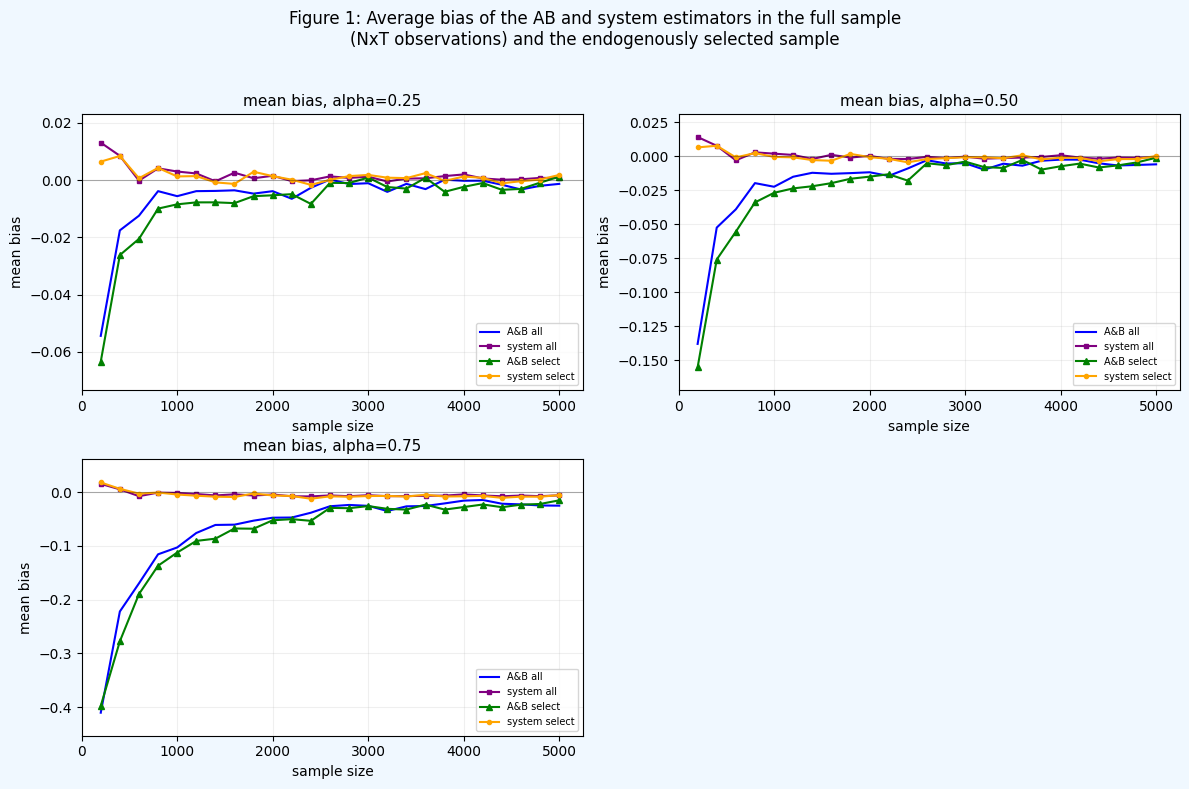


TODAS LAS TABLAS Y FIGURAS GENERADAS CON FORMATO DEL PAPER
Archivos creados:
   - Tabla 1: Formato del paper
   - Tablas 2-3: Formato del paper
   - figura1_sadoon_paper_format.png: Colores y estilos del paper


In [1]:
# Script para construir Tablas 1, 2, 3 y Figura 1 con formato exacto del paper Sadoon et al. (2019)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ------------------- Cargar resultados -------------------
print("Cargando resultados de simulaciones...")
try:
    results = pd.read_csv("resultados.csv")
    print(f"Cargados {len(results)} resultados")
except FileNotFoundError:
    print("No se encontró 'resultados.csv'")
    print("Ejecuta primero el script de generación de datos")
    exit()

# ------------------- TABLA 1 - FORMATO DEL PAPER -------------------
def make_table1_paper_format(df):
    """Genera Tabla 1 con formato del paper"""
    print("\n" + "="*85)
    print("Table 1: Average bias in the AR(1) model (T = 7, 500 replications)")
    print("="*85)
    
    # Datos
    no_endog = df[df['expt'] == 'no_endogenous'].copy()
    endog = df[df['expt'] == 'baseline'].copy()
    
    # Header de la tabla con alineación perfecta
    print("                           No endogenous        Endogenous")
    print("                             selection          selection")
    print("Select.         ρ         (1)      (2)       (3)      (4)")
    print("Model                     AB      SYS        AB      SYS")
    print("                                N = 500")
    
    # Modelo A, N=500
    for rho in [0.25, 0.5, 0.75]:
        no_end_row = no_endog.query("N == 500 & selection == 'A' & rho == @rho")
        end_row = endog.query("N == 500 & selection == 'A' & rho == @rho")
        
        # Línea de bias
        if len(no_end_row) > 0 and len(end_row) > 0:
            no_ab_bias = no_end_row['AB_bias'].values[0]
            no_sys_bias = no_end_row['SYS_bias'].values[0]
            end_ab_bias = end_row['AB_bias'].values[0]
            end_sys_bias = end_row['SYS_bias'].values[0]
            
            print(f"A         {rho:4.2f}  bias  {no_ab_bias:8.5f} {no_sys_bias:8.5f}  {end_ab_bias:8.5f} {end_sys_bias:8.5f}")
            
            # Línea de s.e.
            no_ab_se = no_end_row['AB_se'].values[0]
            no_sys_se = no_end_row['SYS_se'].values[0]
            end_ab_se = end_row['AB_se'].values[0]
            end_sys_se = end_row['SYS_se'].values[0]
            
            print(f"               s.e.  {no_ab_se:8.5f} {no_sys_se:8.5f}  {end_ab_se:8.5f} {end_sys_se:8.5f}")
    
    print("                                N = 5000")
    
    # Modelo A, N=5000
    for rho in [0.25, 0.5, 0.75]:
        no_end_row = no_endog.query("N == 5000 & selection == 'A' & rho == @rho")
        end_row = endog.query("N == 5000 & selection == 'A' & rho == @rho")
        
        if len(no_end_row) > 0 and len(end_row) > 0:
            no_ab_bias = no_end_row['AB_bias'].values[0]
            no_sys_bias = no_end_row['SYS_bias'].values[0]
            end_ab_bias = end_row['AB_bias'].values[0]
            end_sys_bias = end_row['SYS_bias'].values[0]
            
            print(f"A         {rho:4.2f}  bias  {no_ab_bias:8.5f} {no_sys_bias:8.5f}  {end_ab_bias:8.5f} {end_sys_bias:8.5f}")
            
            no_ab_se = no_end_row['AB_se'].values[0]
            no_sys_se = no_end_row['SYS_se'].values[0]
            end_ab_se = end_row['AB_se'].values[0]
            end_sys_se = end_row['SYS_se'].values[0]
            
            print(f"               s.e.  {no_ab_se:8.5f} {no_sys_se:8.5f}  {end_ab_se:8.5f} {end_sys_se:8.5f}")
    
    print("                                N = 500")
    
    # Modelo B, N=500
    for rho in [0.25, 0.5, 0.75]:
        no_end_row = no_endog.query("N == 500 & selection == 'B' & rho == @rho")
        end_row = endog.query("N == 500 & selection == 'B' & rho == @rho")
        
        if len(no_end_row) > 0 and len(end_row) > 0:
            no_ab_bias = no_end_row['AB_bias'].values[0]
            no_sys_bias = no_end_row['SYS_bias'].values[0]
            end_ab_bias = end_row['AB_bias'].values[0]
            end_sys_bias = end_row['SYS_bias'].values[0]
            
            print(f"B         {rho:4.2f}  bias  {no_ab_bias:8.5f} {no_sys_bias:8.5f}  {end_ab_bias:8.5f} {end_sys_bias:8.5f}")
            
            no_ab_se = no_end_row['AB_se'].values[0]
            no_sys_se = no_end_row['SYS_se'].values[0]
            end_ab_se = end_row['AB_se'].values[0]
            end_sys_se = end_row['SYS_se'].values[0]
            
            print(f"               s.e.  {no_ab_se:8.5f} {no_sys_se:8.5f}  {end_ab_se:8.5f} {end_sys_se:8.5f}")
    
    print("                                N = 5000")
    
    # Modelo B, N=5000
    for rho in [0.25, 0.5, 0.75]:
        no_end_row = no_endog.query("N == 5000 & selection == 'B' & rho == @rho")
        end_row = endog.query("N == 5000 & selection == 'B' & rho == @rho")
        
        if len(no_end_row) > 0 and len(end_row) > 0:
            no_ab_bias = no_end_row['AB_bias'].values[0]
            no_sys_bias = no_end_row['SYS_bias'].values[0]
            end_ab_bias = end_row['AB_bias'].values[0]
            end_sys_bias = end_row['SYS_bias'].values[0]
            
            print(f"B         {rho:4.2f}  bias  {no_ab_bias:8.5f} {no_sys_bias:8.5f}  {end_ab_bias:8.5f} {end_sys_bias:8.5f}")
            
            no_ab_se = no_end_row['AB_se'].values[0]
            no_sys_se = no_end_row['SYS_se'].values[0]
            end_ab_se = end_row['AB_se'].values[0]
            end_sys_se = end_row['SYS_se'].values[0]
            
            print(f"               s.e.  {no_ab_se:8.5f} {no_sys_se:8.5f}  {end_ab_se:8.5f} {end_sys_se:8.5f}")

# ------------------- TABLAS 2 y 3 - FORMATO DEL PAPER -------------------
def make_sensitivity_tables_paper_format(df):
    """Genera Tablas 2 y 3 con formato del paper"""
    
    experiments = {
        'short_T': 'Experiment I: Very short T (T = 4)',
        'more_selection': 'Experiment II: More sample selection (25%)',
        'high_alpha_ratio': 'Experiment III: Increasing the ratio of variances: ση/σε = 2',
        'low_corr': 'Experiment IV: Reducing the correlation of the errors: ρ = 0.25',
        'nonstationary': 'Experiment V: Non-stationary time-varying error components'
    }
    
    for table_n, N in enumerate([500, 5000], 2):
        print(f"\n" + "="*90)
        print(f"Table {table_n}: Average bias in the AR(1) model. Sensitivity analysis for {'small' if N==500 else 'large'} N")
        print("="*90)
        
        # Header
        print("Model               ρ = 0.25      ρ = 0.5       ρ = 0.75")
        print("                   AB    SYS    AB    SYS    AB    SYS")
        
        sens_data = df[df['N'] == N].copy()
        
        for exp_key, exp_name in experiments.items():
            if exp_key not in sens_data['expt'].values:
                continue
                
            print(f"                   {exp_name}")
            
            for sel_model in ['A', 'B']:
                # Fila de bias
                bias_values = []
                se_values = []
                
                for rho in [0.25, 0.5, 0.75]:
                    row_data = sens_data.query("expt == @exp_key & selection == @sel_model & rho == @rho")
                    if len(row_data) > 0:
                        ab_bias = row_data['AB_bias'].values[0]
                        ab_se = row_data['AB_se'].values[0]
                        sys_bias = row_data['SYS_bias'].values[0]
                        sys_se = row_data['SYS_se'].values[0]
                        
                        bias_values.extend([ab_bias, sys_bias])
                        se_values.extend([ab_se, sys_se])
                    else:
                        bias_values.extend([np.nan, np.nan])
                        se_values.extend([np.nan, np.nan])
                
                # Imprimir filas
                bias_str = "  ".join([f"{v:7.5f}" if not np.isnan(v) else "    NaN" for v in bias_values])
                se_str = "  ".join([f"{v:7.5f}" if not np.isnan(v) else "    NaN" for v in se_values])
                
                print(f"{sel_model}        bias  {bias_str}")
                print(f"         s.e.  {se_str}")

# ------------------- FIGURA 1 - COLORES Y ESTILOS DEL PAPER -------------------
def make_figure1_paper_format(df):
    """Genera Figura 1 con colores y estilos del paper"""
    print("\nGenerando Figura 1 con formato del paper...")
    
    # Usar datos especiales de figure1
    figure_data = df[df['expt'] == 'figure1'].copy()
    
    if len(figure_data) == 0:
        print("No se encontraron datos de 'figure1'. Usando datos baseline...")
        figure_data = df[df['expt'] == 'baseline'].copy()
    else:
        print(f"Usando {len(figure_data)} datos especiales para Figura 1")
    
    # Configurar la figura con más espacio para el título y fondo celeste
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.patch.set_facecolor('#f0f8ff')  # Fondo celeste para toda la figura
    axes = axes.flatten()
    
    # Colores y estilos según el paper (líneas más finas)
    styles = {
        ('AB', 'A'): {'color': 'blue', 'linestyle': '-', 'marker': '', 'linewidth': 1.5, 'markersize': 0, 'label': 'A&B all'},
        ('AB', 'B'): {'color': 'green', 'linestyle': '-', 'marker': '^', 'linewidth': 1.5, 'markersize': 4, 'label': 'A&B select'},
        ('SYS', 'A'): {'color': 'purple', 'linestyle': '-', 'marker': 's', 'linewidth': 1.5, 'markersize': 3, 'label': 'system all'},
        ('SYS', 'B'): {'color': 'orange', 'linestyle': '-', 'marker': 'o', 'linewidth': 1.5, 'markersize': 3, 'label': 'system select'}
    }
    
    rho_values = [0.25, 0.50, 0.75]
    
    for i, rho in enumerate(rho_values):
        ax = axes[i]
        
        # Datos para este valor de rho
        rho_data = figure_data[figure_data['rho'] == rho].copy()
        
        # Plotear cada combinación
        for sel_model in ['A', 'B']:
            model_data = rho_data[rho_data['selection'] == sel_model].sort_values('N')
            
            if len(model_data) > 0:
                # AB estimator
                ab_style = styles[('AB', sel_model)]
                if ab_style['marker']:
                    ax.plot(model_data['N'], model_data['AB_bias'], 
                           color=ab_style['color'], linestyle=ab_style['linestyle'],
                           marker=ab_style['marker'], linewidth=ab_style['linewidth'],
                           markersize=ab_style['markersize'], label=ab_style['label'])
                else:
                    ax.plot(model_data['N'], model_data['AB_bias'], 
                           color=ab_style['color'], linestyle=ab_style['linestyle'],
                           linewidth=ab_style['linewidth'], label=ab_style['label'])
                
                # System estimator
                sys_style = styles[('SYS', sel_model)]
                ax.plot(model_data['N'], model_data['SYS_bias'], 
                       color=sys_style['color'], linestyle=sys_style['linestyle'],
                       marker=sys_style['marker'], linewidth=sys_style['linewidth'],
                       markersize=sys_style['markersize'], label=sys_style['label'])
        
        # Línea en cero
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.8)
        
        # Formato
        ax.set_xlabel('sample size', fontsize=10)
        ax.set_ylabel('mean bias', fontsize=10)
        ax.set_title(f'mean bias, alpha={rho:.2f}', fontsize=11, fontweight='normal')
        # Leyenda siempre abajo a la derecha
        ax.legend(fontsize=7, loc='lower right')
        ax.grid(True, alpha=0.2)
        
        # Límites
        if len(figure_data) > 0:
            max_n = figure_data['N'].max()
            ax.set_xlim(0, max_n * 1.05)
            ax.set_xticks([0, 1000, 2000, 3000, 4000, 5000])
        
        # Ajustar límites del eje y
        if len(rho_data) > 0:
            all_biases = np.concatenate([rho_data['AB_bias'].values, rho_data['SYS_bias'].values])
            all_biases = all_biases[~np.isnan(all_biases)]
            if len(all_biases) > 0:
                y_range = np.max(all_biases) - np.min(all_biases)
                y_margin = max(0.01, y_range * 0.1)
                y_min, y_max = np.min(all_biases) - y_margin, np.max(all_biases) + y_margin
                ax.set_ylim(y_min, y_max)
    
    # Ocultar el cuarto subplot
    axes[3].set_visible(False)
    
    # Ajustar layout con más espacio arriba para el título
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    # Título sin solapamiento
    plt.suptitle('Figure 1: Average bias of the AB and system estimators in the full sample\n' + 
                 '(NxT observations) and the endogenously selected sample', 
                 fontsize=12, fontweight='normal')
    
    # Guardar figura
    plt.savefig('figura1_sadoon_paper_format.png', dpi=300, bbox_inches='tight')
    print("Figura 1 guardada como 'figura1_sadoon_paper_format.png'")
    plt.show()

# ------------------- EJECUTAR TODO -------------------
if __name__ == "__main__":
    print("="*80)
    print("GENERACIÓN DE TABLAS Y FIGURAS - FORMATO SADOON ET AL. (2019)")
    print("="*80)
    
    # Verificar datos
    print(f"Datos cargados: {len(results)} resultados")
    print(f"Experimentos: {sorted(results['expt'].unique())}")
    
    # Generar outputs con formato del paper
    make_table1_paper_format(results)
    make_sensitivity_tables_paper_format(results)
    make_figure1_paper_format(results)
    
    print("\n" + "="*80)
    print("TODAS LAS TABLAS Y FIGURAS GENERADAS CON FORMATO DEL PAPER")
    print("Archivos creados:")
    print("   - Tabla 1: Formato del paper")
    print("   - Tablas 2-3: Formato del paper") 
    print("   - figura1_sadoon_paper_format.png: Colores y estilos del paper")
    print("="*80)